<img src='images/gdd-logo.png' width='300px' align='right' style="padding: 15px">


# Parameter tuning

So far, you have focused on increasing model performance by making the best out of your data (with categorical feature encodings and imputation of missing values). In this notebook, you will rather focus on the model and its hyperparameters and explore best practices for hyperparameter tuning with Scikit-Learn.

**Program**
- [Baseline model](#review)
    - [<mark>Exercise</mark>](#ex1)
- [Addressing Overfitting](#overfitting)
- [Reducing the complexity](#reduce)
- [Hyperparameter Tuning](#hyper)
    - [<mark>Bonus: Build the best model</mark>](#bonus)
- [Conclusion and next steps](#conc)

Let's first import all the libraries you will need for this notebook:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import RocCurveDisplay

We will again work with the `stroke` data from before:

In [62]:
stroke = pd.read_csv('data/stroke.csv').rename(columns=str.lower)
stroke.head()

,id,address,gender,age,who,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,"Vanessaside, VT 79393",Male,67.0,Man,0,1,1,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,APO AA 41945,Female,NaN,Woman,0,0,1,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,"North Jenniferfurt, VT 88077",Male,80.0,Man,0,1,1,Private,Rural,105.92,32.5,never smoked,1
3,60182,"Rodriguezside, LA 93111",Female,49.0,Woman,0,0,1,Private,Urban,171.23,34.4,smokes,1
4,1665,"Ivanburgh, AZ 80818",Female,79.0,Woman,1,0,1,Self-employed,Rural,174.12,24.0,never smoked,1


## Baseline Model

The Decision Tree Classifier (using categorical features) from the previous notebook will act as the baseline model going forward. 

Below, you can see the pipeline we created in the first notebook:

In [65]:
# Variable definitions
categorical_cols = ['work_type', 'smoking_status', 'who', 'gender', 'residence_type']
missing_cols = ['age','bmi']
drop_cols = ['id','address']

target = 'stroke'

def create_Xy(df, drop_cols, target_col):
    df = df.drop(columns=drop_cols)
    return (
        df.drop(columns=target_col),
        df[target_col]
    )

# Create X and y
X, y = stroke.pipe(create_Xy, 
                   drop_cols=drop_cols, 
                   target_col=target,
                   )

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify = y,
                                                    )

In [4]:
# Step 1: import model
from sklearn.tree import DecisionTreeClassifier

# Step 2: Instantiate model and set parameters
model = DecisionTreeClassifier(max_depth=3, 
                               class_weight='balanced', 
                               random_state=123)

ct = ColumnTransformer([
    ('onehot', OneHotEncoder(drop="if_binary"), categorical_cols)
], remainder='passthrough')

preprocessing = Pipeline(steps=[
    ('onehot', ct),
    ('impute', SimpleImputer(strategy='mean')),
])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('model', model)
])

# Step 3: Train model
pipeline.fit(X_train,y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('onehot',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehot',
                                                                   OneHotEncoder(drop='if_binary'),
                                                                   ['work_type',
                                                                    'smoking_status',
                                                                    'who',
                                                                    'gender',
                                                                    'residence_type'])])),
                                 ('impute', SimpleImputer())])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                                        random_state=123))])

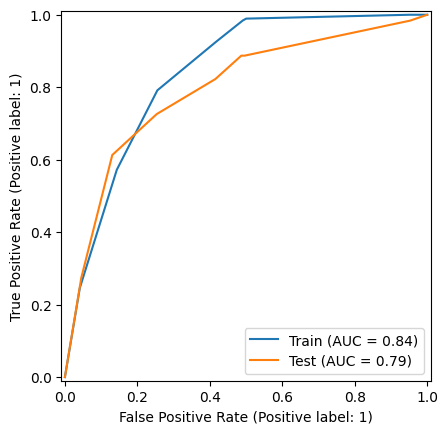

In [26]:
# Step 4: Evaluate model
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(pipeline, X_train, y_train, ax=ax, name='Train')
RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=ax, name='Test')

The training and test AUC are quite good already, but we can surely get them higher, right?

#### <mark>Exercise:</mark> Changing model parameters

Change the hyperparameters of the `DecisionTreeClassifier` to improve its performance.

1. What is the default parameter value for `max_depth`? What does it do?
2. Change the `max_depth` parameter to improve model performance. What happens to the training and test AUC, if you leave it at the default?
3. Find out what other hyperparameters you can tune (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)). Which ones would be worth changing as well?
4. The model is overfitting with the default parameters. What does ***overfitting*** mean?

<details>
  <summary><span style="color:blue">Show solution</span></summary>

1. Default is `None`, meaning there is no restriction on the maximum depth.    
2. Setting `max_depth` to 20 will result in worse test accuracy and almost 100% training accuracy = the model is overfitting the training data.
3. `min_sample_leaf` and `min_sample_split` are also parameters that may be worth tuning. With the defaults `1` and `2`, the model is allowed to create splits that could separate individual samples, which is part of why it is overfitting so drastically.
4. Overfitting means the model fitted too well (or even perfectly) on the training data and did not learn a meaningful pattern. It is thus too specific and cannot generalize well to new, unseen data.


</details>

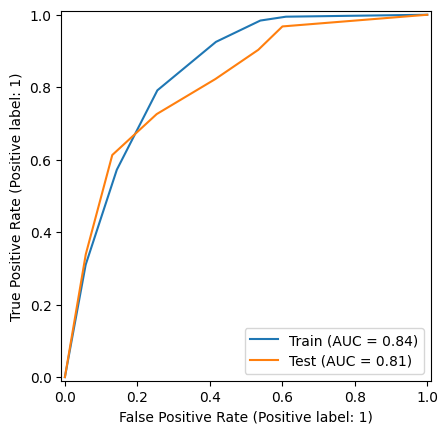

In [ ]:
# Change the parameters!
new_model = DecisionTreeClassifier(
    max_depth=3,
    # add other parameters here
    class_weight='balanced', 
    random_state=123,
    min_samples_leaf=250,
    min_samples_split=4,
    )

new_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('model', new_model)
])

new_pipeline.fit(X_train,y_train)

fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(new_pipeline, X_train, y_train, ax=ax, name='Train')
RocCurveDisplay.from_estimator(new_pipeline, X_test, y_test, ax=ax, name='Test')

In [ ]:
# %load answers/03-changing-hyperparameters.py

# With default model parameters
new_model = DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    class_weight='balanced', 
    random_state=42)

new_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('model', new_model)
])

new_pipeline.fit(X_train,y_train)

fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(new_pipeline, X_train, y_train, ax=ax, name='Train')
RocCurveDisplay.from_estimator(new_pipeline, X_test, y_test, ax=ax, name='Test')

# With default parameters, the model is massively overfitting!

<mark>**Bonus:**</mark> 

**Precision**, **Recall** and their harmonic mean - the **F1-Score** - are other common metrics for classifiers. 
- Look up what they mean and why they are useful.
- Calculate Precision & Recall and the F1-Score for the model (hint: Use the function `classification_report()` from `sklearn.metrics`)
- Would you focus on maximizing precision or recall in this use case?

<details>
  <summary><span style="color:blue">Show solution</span></summary>

The **precision** for a class is the number of correctly classified positives (e.g., stroke classifications that actually had stroke) divided by the total number of all classified positives, i.e., the sum of true positives and false positives (total positive stroke classifications).

**Recall** is defined as the number of true positives divided by the total number of true positives in the dataset (e.g., how many actual stroke victims did the model correctly identify).

<img src="images/precision_recall.png" width="500" align="center">

**F1 score** combines both precision and recall by calculating their harmonic mean:

$${\displaystyle F_{1}={\frac {2}{\mathrm {recall} ^{-1}+\mathrm {precision} ^{-1}}}=2\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}={\frac {\mathrm {tp} }{\mathrm {tp} +{\frac {1}{2}}(\mathrm {fp} +\mathrm {fn} )}}}$$


</details>

In [53]:
from sklearn.metrics import classification_report

# your code here
preds = new_pipeline.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1216
           1       0.13      0.73      0.22        62

    accuracy                           0.75      1278
   macro avg       0.55      0.74      0.53      1278
weighted avg       0.94      0.75      0.82      1278



In [51]:
# %load answers/03-metrics-classification-report.py

preds = new_pipeline.predict(X_test)

print(classification_report(y_test, preds))

# For a medical dataset, recall as it is better to maximize since you typically want to capture as many 
# true positive cases as possible.

<a id=overfitting></a>

## Addressing Overfitting

The results above show us that the algorithm can severely overfit on the training data.

There are many ways to address overfitting, including:

- **Train with more data**: It won't work every time, but training with more data can help algorithms detect the signal better. This can involve data augmentation if needed.
- **Remove features**: If you have a large number of features, you should only select the most important features for training so that the model doesn’t learn from features that don't generalise well. 
- ★ **Reduce the complexity of the model**: An over-complex model is more likely to overfit. You can directly reduce the model’s complexity by looking at the type of model, or the specific model parameters.

Let's focus on the easiest to begin with - reducing the complexity of the model.

<a id=reduce></a>
### Reduce the complexity of the model

Leaving the `max_depth` parameter unrestricted increases model complexity a lot.

We can see this by plotting the default tree:

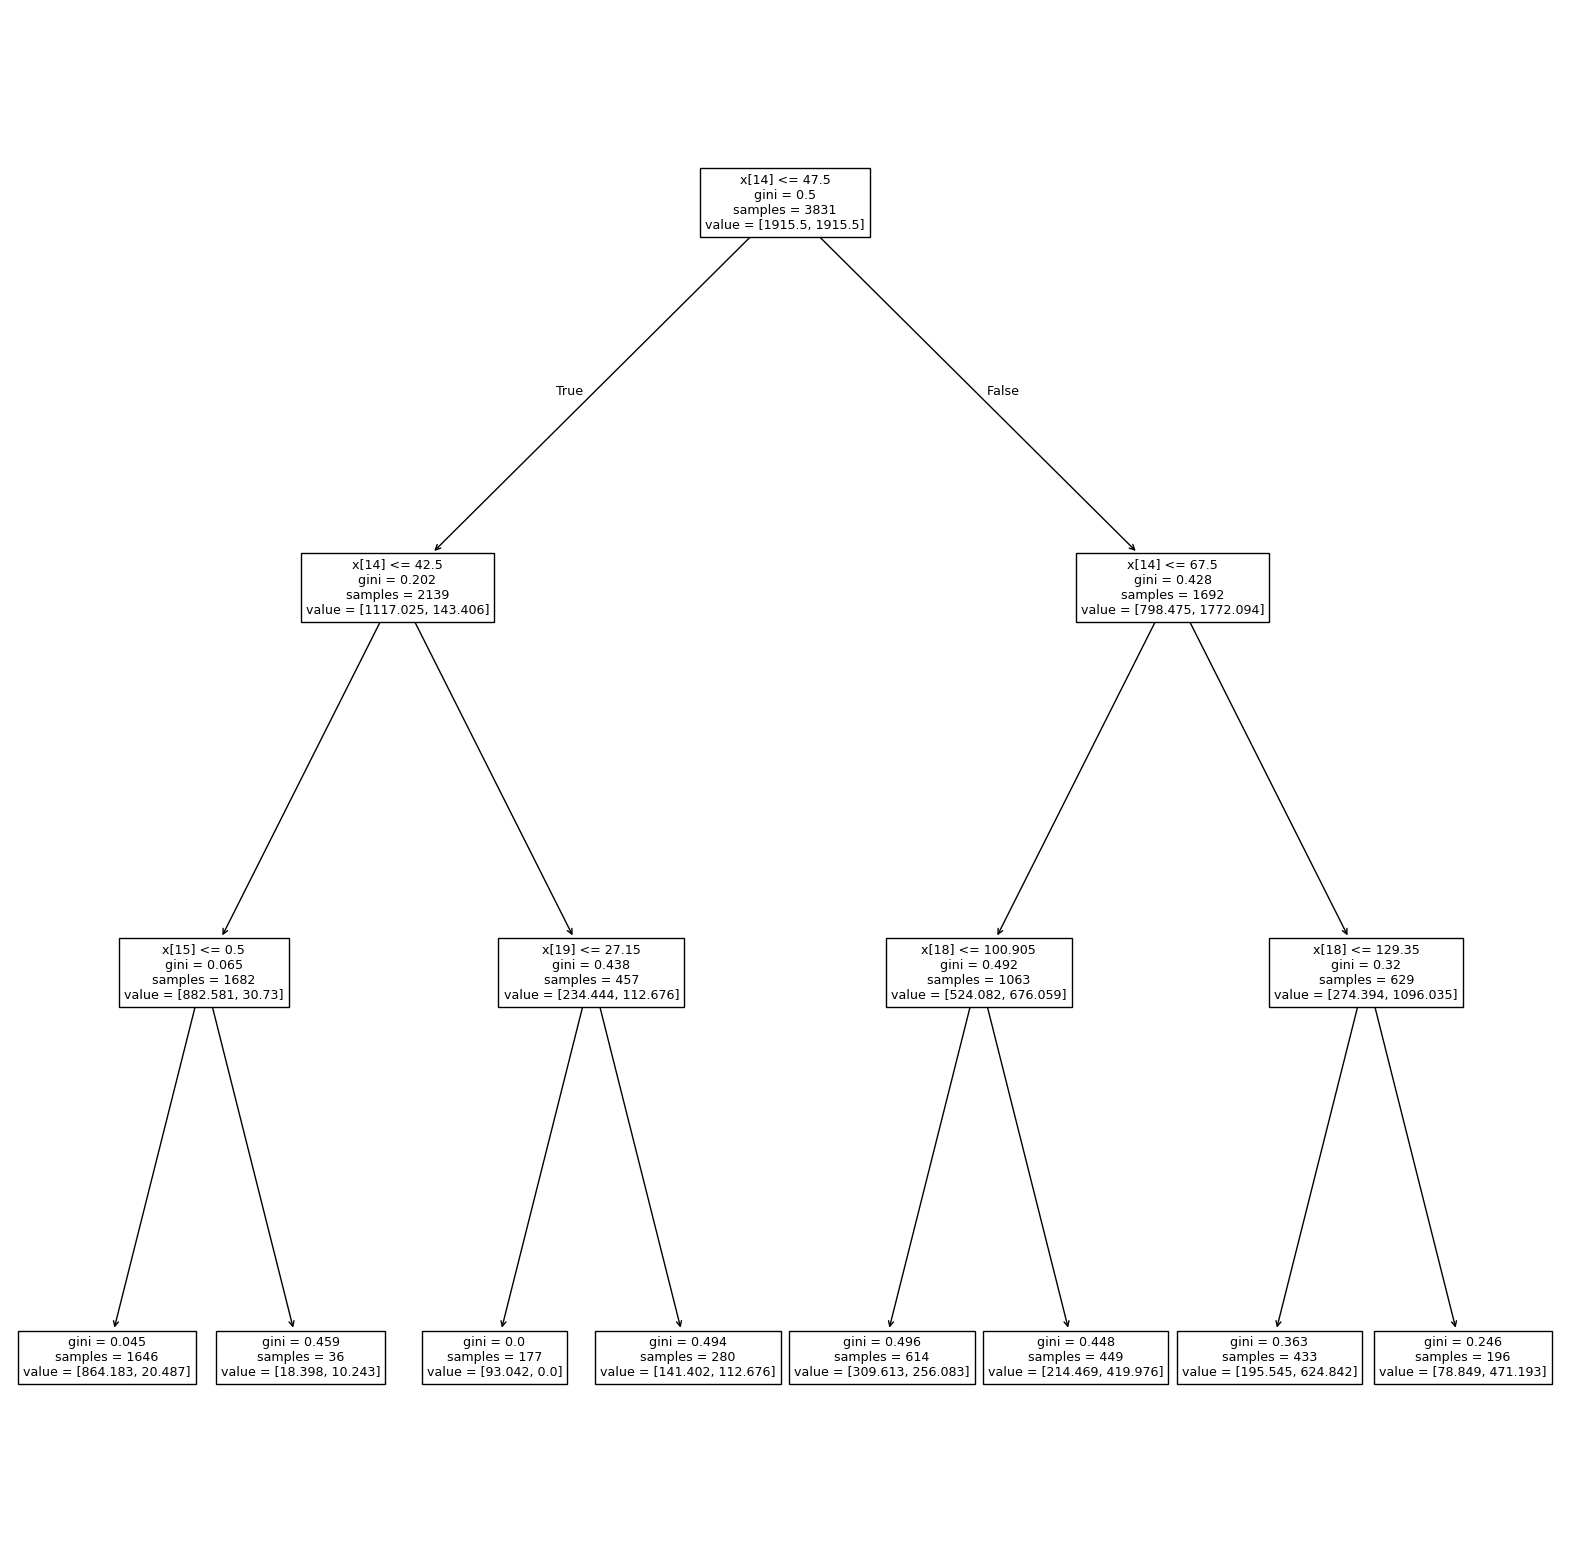

In [10]:
from sklearn.tree import plot_tree

fig,ax = plt.subplots(figsize=(20,20))

plot_tree(new_pipeline.named_steps['model'], ax=ax);

<mark>**Question:**</mark> What is the maximum number of end leaf nodes a tree could get to with a max depth of 50?

<details>
  <summary><span style="color:blue">Show solution</span></summary>

   Each split generates two new leaves. So 50 splits generate 2^50 (1.1 trillion) end nodes.

</details>

<a id=hyper></a>

### Hyperparameter Tuning

It would of course be a good idea to do some hyperparameter tuning to find the best value for `max_depth` (and/or other parameters).

In the exercise before, you have tried to tune these model parameters by hand. Of course, this is not the best idea since it is time-consuming and inefficient.
 
For this problem, sklearn already contains a **Grid Search** algorithm called `GridSearchCV` which will allow you to test different paramter combinations on the dataset using ***Cross Validation***.

<details>
  <summary><span style="color:blue">Refresher Cross-Validation</span></summary>

Cross Validation (CV), specifically k-fold cross validation allows you to train and test your algorithm on multiple, mutually exclusive subsets of your data, giving you a better estimate of the true performance. 

Hereby, the data is split into k equally sized subsets, whereby one is used as a validation set and the remaining k-1 for training (repeating the process for k iterations). After wards, the performance metrics of the k train-validation iterations are averaged.

Usually, a small proportion of the data is held out completely as a separate test set for final evaluation.

<img src="images/crossvalidation.png" style="display: block;margin-left: auto;margin-right: auto;height: 300px"/>

</details>



In [11]:
from sklearn.model_selection import GridSearchCV

The `GridSearchCV` object requires a parameter grid (as a `{key: value}` dictionary) with the different options you want to explore.

In [12]:
params = {
    'preprocessing__impute__strategy': ['mean', 'median'],
    'model__max_depth': range(1, 21),
    'model__criterion': ['gini','entropy',],
}

You can then perform a parameter grid sesarch to optimise your chosen metric.

In [13]:
grid = GridSearchCV(pipeline, params, scoring='roc_auc', cv = 3)

In [14]:
grid.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('onehot',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('onehot',
                                                                                          OneHotEncoder(drop='if_binary'),
                                                                                          ['work_type',
                                                                                           'smoking_status',
                                                                                           'who',
                                                                                           'gender',
                                                                                           'residence_type'])])),
                                                        ('impute',
                                                         SimpleImputer())])),
                                       ('model',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               max_depth=3,
                                                               random_state=123))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': range(1, 21),
                         'preprocessing__impute__strategy': ['mean', 'median']},
             scoring='roc_auc')

In [15]:
cv_results = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,param_preprocessing__impute__strategy,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
43,0.013480,0.000277,0.006235,0.000081,entropy,2,median,"{'model__criterion': 'entropy', 'model__max_de...",0.812459,0.806093,0.811361,0.809971,0.002778,1
3,0.013681,0.000538,0.006159,0.000041,gini,2,median,"{'model__criterion': 'gini', 'model__max_depth...",0.805429,0.806093,0.811034,0.807519,0.002500,2
2,0.011689,0.000210,0.006269,0.000095,gini,2,mean,"{'model__criterion': 'gini', 'model__max_depth...",0.801434,0.804819,0.811034,0.805762,0.003976,3
45,0.014434,0.000459,0.006259,0.000034,entropy,3,median,"{'model__criterion': 'entropy', 'model__max_de...",0.801799,0.777950,0.819762,0.799837,0.017126,4
42,0.012781,0.000621,0.007152,0.001123,entropy,2,mean,"{'model__criterion': 'entropy', 'model__max_de...",0.800863,0.784375,0.811034,0.798757,0.010985,5


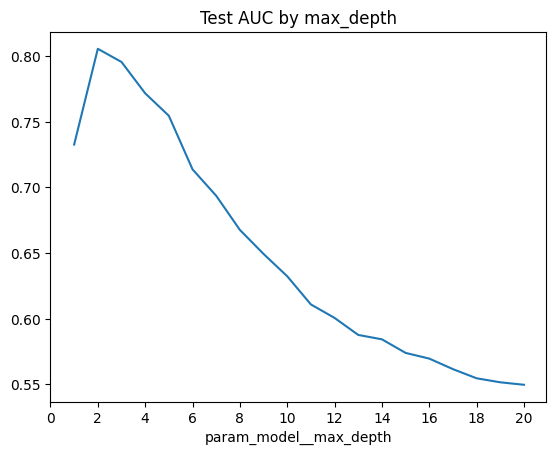

In [16]:
(
    cv_results
    .groupby('param_model__max_depth')
    ['mean_test_score']
    .mean()
    .plot(title = 'Test AUC by max_depth', 
          xticks = range(0,21,2)
          )
);

We can then select the best model:

In [17]:
model_best = grid.best_estimator_
model_best

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('onehot',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehot',
                                                                   OneHotEncoder(drop='if_binary'),
                                                                   ['work_type',
                                                                    'smoking_status',
                                                                    'who',
                                                                    'gender',
                                                                    'residence_type'])])),
                                 ('impute',
                                  SimpleImputer(strategy='median'))])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=2,
                                        random_state=123))])

In [18]:
model_best.score(X_train, y_train), model_best.score(X_test, y_test)

(0.5137039937353172, 0.5140845070422535)

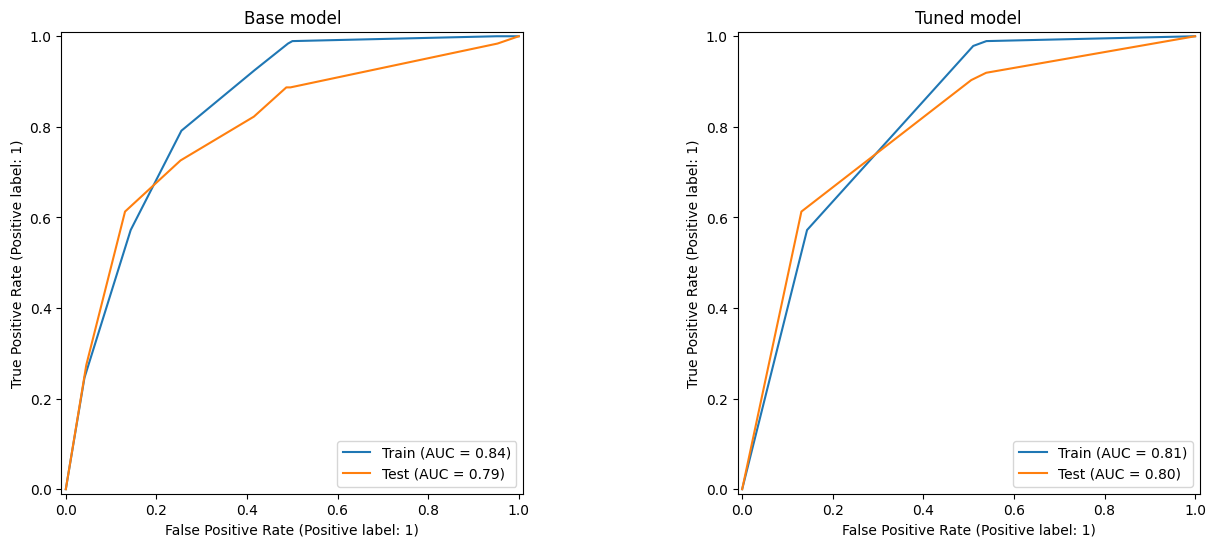

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))

RocCurveDisplay.from_estimator(pipeline, X_train, y_train, ax=ax[0], name='Train')
RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=ax[0], name='Test')
ax[0].set(title='Base model')

RocCurveDisplay.from_estimator(model_best, X_train, y_train, ax=ax[1], name='Train')
RocCurveDisplay.from_estimator(model_best, X_test, y_test, ax=ax[1], name='Test')
ax[1].set(title='Tuned model');

<a id=bonus></a>

### <mark>Bonus:</mark> Build your best model

It is now your turn to put it all together and see if you can build a better model.

1. Build a model pipeline that **maximizes test performance (AUC)**
2. Select a machine learning model of your choice (see here for [sklearn selection](https://scikit-learn.org/stable/supervised_learning.html))
3. Look up what hyperparameters it has and perform a grid search to tune its hyperparameters.

*Hint: In real use cases, more complex models such as Random Forests, Support Vector Machines, or Gradient Boosting models are more often used (as they are generally more performant).*

In [59]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# # your code here
grid = GridSearchCV(pipeline, params, scoring='roc_auc', cv = 3)
grid.fit(X_train, y_train)

cv_results = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
cv_results.head()

model_best = grid.best_estimator_
model_best

/home/codespace/.local/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('onehot',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehot',
                                                                   OneHotEncoder(drop='if_binary'),
                                                                   ['work_type',
                                                                    'smoking_status',
                                                                    'who',
                                                                    'gender',
                                                                    'residence_type'])])),
                                 ('impute',
                                  SimpleImputer(strategy='median'))])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=2,
                                        random_state=123))])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__max_features,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.167781,0.057004,0.008337,0.000123,2,sqrt,100,"{'model__max_depth': 2, 'model__max_features':...",0.837993,0.822242,0.825868,0.828701,0.006735,1
1,0.280667,0.036377,0.012200,0.001892,2,sqrt,200,"{'model__max_depth': 2, 'model__max_features':...",0.839466,0.818877,0.825769,0.828038,0.008557,2
2,0.205050,0.022298,0.012025,0.002535,2,10,100,"{'model__max_depth': 2, 'model__max_features':...",0.833333,0.821937,0.827554,0.827608,0.004653,3
4,0.164328,0.000995,0.008724,0.000133,3,sqrt,100,"{'model__max_depth': 3, 'model__max_features':...",0.840130,0.814602,0.817362,0.824032,0.011439,4
6,0.243723,0.007921,0.008472,0.000048,3,10,100,"{'model__max_depth': 3, 'model__max_features':...",0.836791,0.815532,0.811433,0.821252,0.011115,5


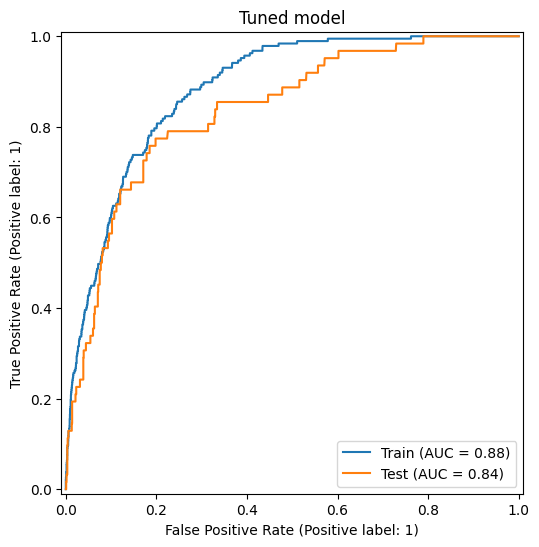

In [61]:
# %load answers/03-better-model.py

# Instantiate model
better_model = GradientBoostingClassifier(
    # class_weight='balanced',
    random_state=42,
    )

# Model pipeline
better_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('model', better_model)
])

# GridSearchCV
better_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': range(2,6),
    'model__max_features': ['sqrt', 10]
}

better_grid = GridSearchCV(better_pipeline, better_params, scoring='roc_auc', cv = 3)
better_grid.fit(X_train, y_train)
better_results = pd.DataFrame(better_grid.cv_results_).sort_values('rank_test_score')
display(better_results.head())
best_gbf = better_grid.best_estimator_

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8,6))
RocCurveDisplay.from_estimator(best_gbf, X_train, y_train, ax=ax, name='Train')
RocCurveDisplay.from_estimator(best_gbf, X_test, y_test, ax=ax, name='Test')
ax.set(title='Tuned model');

<details>
    
  <summary><span style="color:blue">Read about how to add different models to your hyperparameter search here. </span></summary>
  
## More control over the hyperparameter search

Let's now consider a scenario where you want to compare two different classifiers, a support vector machine and a random forest one.

Naively, you could create a dictionary like the following:

```python
all_parameters = {'classifier': [SVC(), RandomForestClassifier()],
                  'classifier__C': [.5, 1, 1.5], # SVC hyperparam
                  'classifier__kernel': ["linear", "poly", "rbf"], # SVC hyperparam
                  'classifier__n_estimators': [40, 60, 90], # RFC hyperparam
                  'classifier__max_depth': [2, 3, 5, 10], # RFC hyperparam
                  'classifier__min_samples_leaf': [1,5,8] # RFC hyperparam
                   }
```
However, if you use this dictionary with `GridSearchCV`, the search will explore all possible combinations of hyperparameters. For example, it will fit pipelines with a `RandomForestClassifier()` for every combination of the `C` and `kernel` hyperparameters. This would be a waste of resources since those hyperparameters are not related to the `RandomForestClassifier()`. 

To avoid this issue, `GridSearchCV` also accepts a _list_ of dictionaries as an input to give you more control over what combinations of hyperparameters are tested. It will only compare all possible combination of hyperparameters *within* each dictionary.


```python
svc_parameters = {'classifier': [SVC()],
                  'classifier__C': [.5, 1, 1.5],
                  'classifier__kernel': ["linear", "poly", "rbf"],
                   }
```

```python
rf_parameters = {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [40, 60, 90],
                 'classifier__max_depth': [2, 3, 5, 10],
                 'classifier__min_samples_leaf': [1,5,8]
                   }
```

```python
grid_all = GridSearchCV(pipeline, 
                        [svc_parameters, rf_parameters], 
                        scoring='accuracy')
```


</details>


---

<a id=conc></a>
# Conclusion and Next Steps
<img src='images/gdd-logo.png' width='300px' align='right' style="padding: 15px">

This notebook has covered an overview of ensemble algorithms, with a particular focus on the random forest. Also covered was overfitting and using hyperparameter tuning to correct issues of overfitting. 

In the next notebook you will explore another ensemble algorithm - Gradient Boosting.